In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
matplotlib.style.use('ggplot')
import pickle as pkl
import itertools
import random
from collections import namedtuple
from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model

2024-12-05 23:24:25.881133: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data exploration

<Axes: xlabel='Date', ylabel='cumm return'>

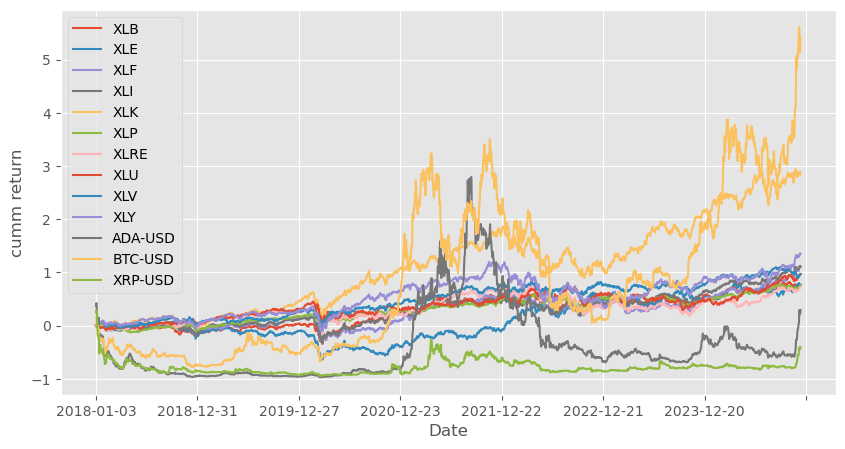

In [101]:
data = pd.read_csv("data/df_pct_change.csv", index_col=0)
cum_return_ts = data.apply(lambda x: x+1).cumprod(axis=0)-1

cum_return_ts.plot(figsize = (10, 5), ylabel="cumm return")

In [30]:
# historical data split into 5
data_split = np.array_split(data, 5)
for i, data in enumerate(data_split):
    data.to_csv(f"data/df_pct_change_{i}.csv")

### Build RL Framework

In [63]:
class PortfolioEnv():
    def __init__(self
                 , input_file='data/df_pct_change_0.csv'
                #  , capital = 1e6
                 , observe_window = 90
                 , rebalance_window = 30
                 , seed = None):  
        self.input_file = input_file     
        # self.capital = capital  
        # self.prices = None # numpy array
        self.returns = None # numpy array
        self.asset_names = None # numpy array
        # self.seed = seed
        # self.rng = np.random.default_rng(self.seed)
        self.observe_window = observe_window
        self.rebalance_window = rebalance_window
        self.t = None # current time
        self.T = None
        self.n_asset = None
        self.done = False

        self._load_data() 
        self.reset()

    def _load_data(self):
        data = pd.read_csv(self.input_file)
        # data.index = data['Date']
        data = data.drop(columns = ['Date'])
        # data2 = data.pct_change().dropna()
        # self.prices = data.values
        self.returns = data.values
        self.asset_names = data.columns
        self.T = data.shape[0]
        self.n_asset = data.shape[1]
    
    def _reset(self, t=None):
        if t is not None:
            self.t = t
        else: 
            self.t = self.observe_window
        self.done = False
        state = self.check_state()
        return state
    
    def reset(self, t=None):
        return self._reset()
    
    def random_reset(self):
        self.t = random.randint(self.observe_window
                                , self.T - self.rebalance_window - 1)
        return self._reset(self.t)

    def check_state(self):
        assert self.observe_window <= self.t
        R_i_ts = self.returns[self.t - self.observe_window : self.t]
        V = np.cov(R_i_ts.T)
        return V
    
    def check_reward(self, action):
        W = self.normalize(action)
        R_i_ts = self.returns[self.t - self.rebalance_window : self.t] # daily returns of the individual assets
        R_i = np.mean(R_i_ts, axis=0)  # mean returns of the individual assets
        V = np.cov(R_i_ts.T)  
        R_p_ts = np.dot(R_i_ts, W)  # daily returns of the portfolio
        r_p = np.sum(np.dot(R_i, W))
        v_p = np.dot(W.T, np.dot(V, W))
        sharpe_ratio = r_p / np.sqrt(v_p)  # Sharpe ratio of the portfolio
        return R_p_ts, sharpe_ratio
    
    def step(self, action):
        reward = ([], None)
        next_state = []
        if (self.t + self.rebalance_window) > self.T:
            self.done = True          
        else: 
            self.t += self.rebalance_window
            next_state = self.check_state()
            reward = self.check_reward(action)  # reward from next state
        return (reward, self.done, next_state)
    
    def normalize(self, action):
        w_sum = np.sum(np.abs(action))
        if np.isclose(1.0, w_sum):
            return action
        else:
            return action / w_sum


In [41]:
class QEstimator:
    """Q-Value Estimator neural network.

    """
    def __init__(self, n_asset):
        
        self.n_asset = n_asset
        self.n_action = 3 # hold, buy, sell
        
        self.model = self._build()

    def _build(self):
        
        inputs = Input(shape=(self.n_asset, self.n_asset, ))        
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)
        
        predictions = []
        for i in range(self.n_asset):
            asset_dense = Dense(self.n_action, activation='linear')(x)   
            predictions.append(asset_dense)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model
    
    def predict(self, state):
        q_values = self.model.predict(np.expand_dims(state, 0), verbose=0)
        return q_values

    def update(self, state, Q):
        self.model.fit(np.expand_dims(state, 0)
                       , Q
                       , epochs=1, verbose=0)

In [42]:
def uni_policy(n_action):
    """
    Creates a policy function w/ output action of same asset weights.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector of action probabilities
    """
    A = np.ones(n_action, dtype=float) / n_action
    def policy_func(state):
        return A
    return policy_func

def epsilon_greedy_policy(n_asset):
    """
    Creates an epsilon-greedy policy based on a given Q-generating model.
    
    Args:
        n_asset: Number of assets in the portfolio
    
    Returns:
        A function that takes q_estimator, state and epsilon as arguments and returns actions
            q_estimator: NN model that generates Q. Q is a map of state -> action-values. Each value is a numpy array of length nA.
            epsilon: The probability to select a random action. Float between 0 and 1.
    
    """
    def generate_actions(Q): # allow_short = False
                        
        Q = np.squeeze(Q)  # (n_assets, 1, n_actions) -> (n_assets, n_actions)
        action_argmax = np.argmax(Q, axis=-1)  # (n_assets,) chosen action according to the max action value
        actions = np.take_along_axis(Q  # (n_assets, 1) chosen action value according to the max action value
                                    , action_argmax.reshape(-1,1)
                                    , axis=-1)
        actions = np.squeeze(actions)  # (n_assets, 1) -> (n_assets,)
        actions = np.where(action_argmax==0, 0  # 0 - hold
                                , np.where(action_argmax==1, abs(actions) # 1 - buy
                                        , -abs(actions))) # 2 - sell

        return actions  # (n_assets,)
    
    def policy_func(state, q_estimator: QEstimator, epsilon):
        
        Q = q_estimator.predict(state)
        best_action = generate_actions(Q)
        random_action = np.random.normal(0, 1, size = (n_asset, )) 
        if random.random() < epsilon:
            action = random_action
        else:
            action = best_action
        return action
    
    return policy_func


In [97]:
def q_learning(env: PortfolioEnv
               , n_episodes
               , alpha=0.5
               , epsilon=1.0
               , epsilon_min=0.01
               , epsilon_decay_rate=0.95
               , gamma=0.95
               , replay_batch_size=10
               ):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy.

    Args:
        env: instance of PortfolioEnv.
        num_episodes: Number of episodes to run for.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
        gamma: discount factor.
        replay_batch_size: reach a certain memory size before replay. Replay is for the model to learn across a set of uncorrelated transitions https://arxiv.org/pdf/1509.02971
    
    Returns:
        q_estimator: NN model that generates Q. Q is a map of state -> action-values. Each value is a numpy array of length nA.
        stats: Episode stats.
    """

    # Keeps track of useful statistics
    EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])
    stats = EpisodeStats(
        episode_lengths=np.zeros(n_episodes)
        , episode_rewards=np.zeros(n_episodes)
    )   
    # Q estimator
    q_estimator=QEstimator(env.n_asset)
    # The policy we're following
    policy = epsilon_greedy_policy(env.n_asset)
    # Benchmark policy (equal weights)
    policy_bm = uni_policy(env.n_asset)

    # The replay memory
    replay_memory = []
    Memory = namedtuple("memory", ["state", "action", "reward", "done", "next_state"])

    for i_eps in range(n_episodes):
        returns_recorder_bm = []
        returns_recorder = []
        actions_recorder = []
        
        print("\nEpisode {}/{}, episilon={}".format(i_eps + 1, n_episodes, epsilon))
        # sys.stdout.flush()
        
        # Reset the environment
        state = env.random_reset()
        
        for t in itertools.count():
            
            # Take a step
            action = policy(state, q_estimator, epsilon)
            action_bm = policy_bm(state)
            reward, done, next_state = env.step(action)
            if done:
                break 
            reward_bm = env.check_reward(action_bm)  #!! Note to calculate rewards for the benchmark after calling env.step() coz it is calculated based on next state.
            # Update recorders and statistics
            returns_recorder_bm.extend(reward_bm[0]) # daily returns of the benchmark portfolio
            actions_recorder.extend(action)
            returns_recorder.extend(reward[0]) # daily returns of the portfolio
            stats.episode_rewards[i_eps] += reward[1] # Sharp ratio of the portfolio
            stats.episode_lengths[i_eps] = t
            
            replay_memory.append(Memory(state, action, reward, done, next_state))

            if len(replay_memory) >= replay_batch_size:
                sample_memory = random.sample(replay_memory, replay_batch_size)
                # Temporal Difference (TD) Update
                for memo in sample_memory:
                    # init
                    Q_reward = np.zeros((q_estimator.n_asset, q_estimator.n_action))
                    Q_next = np.zeros((q_estimator.n_asset, q_estimator.n_action))
                    # restore the chosen action which has max action value given by Q
                    action_argmax = np.where(memo.action==0, 0
                                            , np.where(memo.action>0, 1
                                                    ,2))
                    # give reward to the chosen action
                    np.put_along_axis(Q_reward 
                                    , action_argmax.reshape(-1,1)
                                    , memo.reward[1]  
                                    , axis=-1)
                    if not memo.done:
                        Q_next = np.squeeze(q_estimator.predict(memo.next_state)) 
                    Q_expect = Q_reward + gamma * Q_next
                    Q_now = np.squeeze(q_estimator.predict(memo.state))
                    Q_learn = (1-alpha) * Q_now + alpha * Q_expect
                    Q_learn = [A.reshape(1, -1) for A in Q_learn] # reshape to match model update function
                    # update Q function
                    q_estimator.update(memo.state, Q_learn)  
                    
            # replay_memory = []
            state = next_state
            # end of one episode

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay_rate

        if i_eps % 5 == 0:
            plt.figure(figsize = (12, 2))
            plt.plot(np.cumprod(np.array(returns_recorder)+1)-1, color = 'black', ls = '-')
            plt.plot(np.cumprod(np.array(returns_recorder_bm)+1)-1, color = 'grey', ls = '--')
            plt.show()
        
        # plt.figure(figsize = (12, 2))
        # for a in actions_recorder:    
        #     plt.bar(np.arange(env.n_asset), a, color = 'grey', alpha = 0.25)
        #     plt.xticks(np.arange(env.n_asset), env.asset_names, rotation='vertical')
        # plt.show()

    return q_estimator, stats

### Model Training


Episode 1/65, episilon=1.0


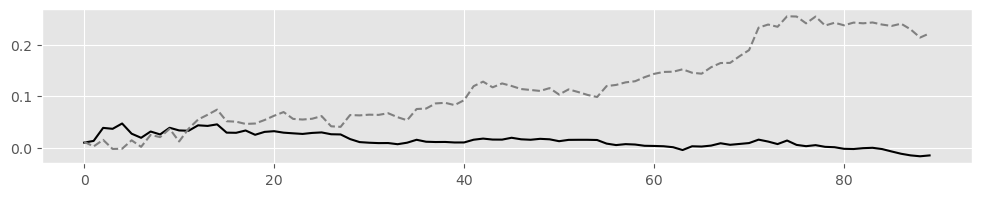


Episode 2/65, episilon=0.95

Episode 3/65, episilon=0.9025

Episode 4/65, episilon=0.8573749999999999

Episode 5/65, episilon=0.8145062499999999

Episode 6/65, episilon=0.7737809374999999


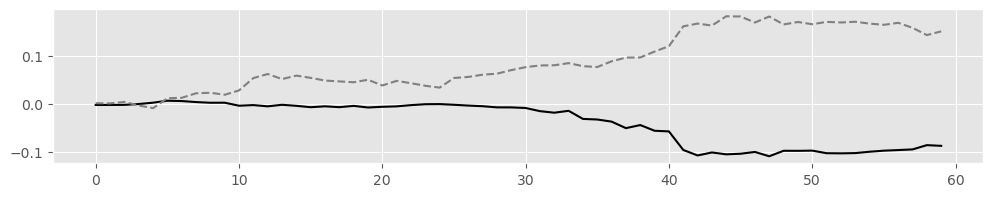


Episode 7/65, episilon=0.7350918906249998

Episode 8/65, episilon=0.6983372960937497

Episode 9/65, episilon=0.6634204312890623

Episode 10/65, episilon=0.6302494097246091

Episode 11/65, episilon=0.5987369392383786


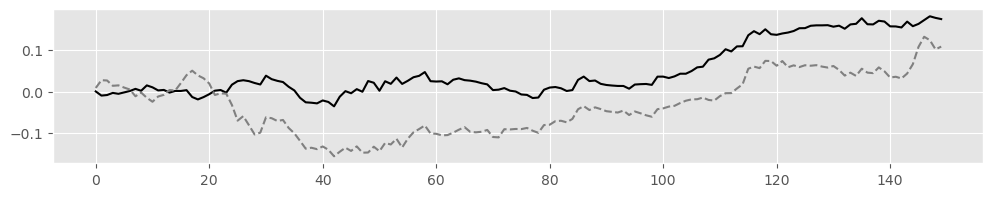


Episode 12/65, episilon=0.5688000922764596

Episode 13/65, episilon=0.5403600876626365

Episode 14/65, episilon=0.5133420832795047

Episode 15/65, episilon=0.48767497911552943

Episode 16/65, episilon=0.46329123015975293


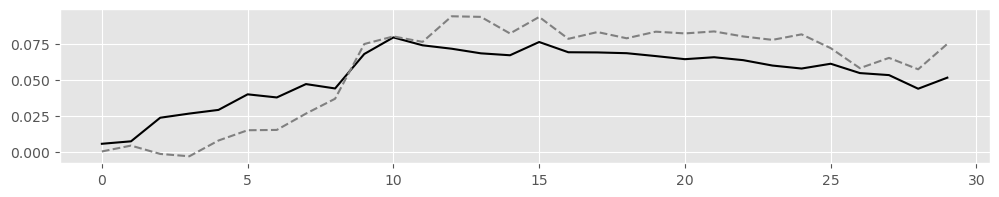


Episode 17/65, episilon=0.44012666865176525

Episode 18/65, episilon=0.41812033521917696

Episode 19/65, episilon=0.3972143184582181

Episode 20/65, episilon=0.37735360253530714

Episode 21/65, episilon=0.35848592240854177


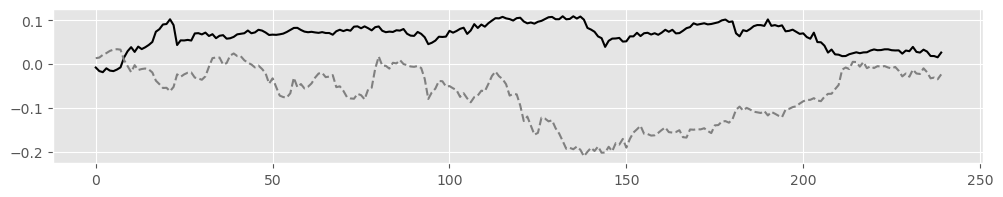


Episode 22/65, episilon=0.34056162628811465

Episode 23/65, episilon=0.3235335449737089

Episode 24/65, episilon=0.30735686772502346

Episode 25/65, episilon=0.2919890243387723

Episode 26/65, episilon=0.27738957312183365


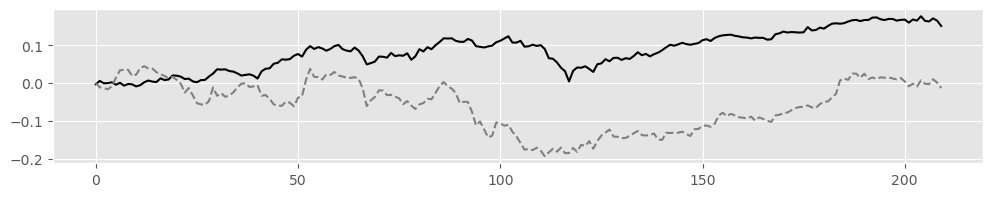


Episode 27/65, episilon=0.263520094465742

Episode 28/65, episilon=0.25034408974245487

Episode 29/65, episilon=0.2378268852553321

Episode 30/65, episilon=0.2259355409925655

Episode 31/65, episilon=0.2146387639429372


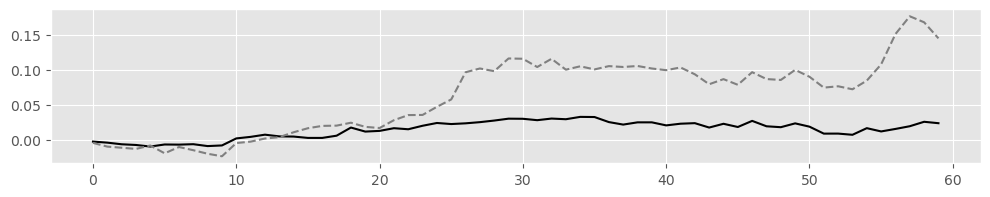


Episode 32/65, episilon=0.20390682574579033

Episode 33/65, episilon=0.1937114844585008

Episode 34/65, episilon=0.18402591023557577

Episode 35/65, episilon=0.17482461472379698

Episode 36/65, episilon=0.16608338398760714


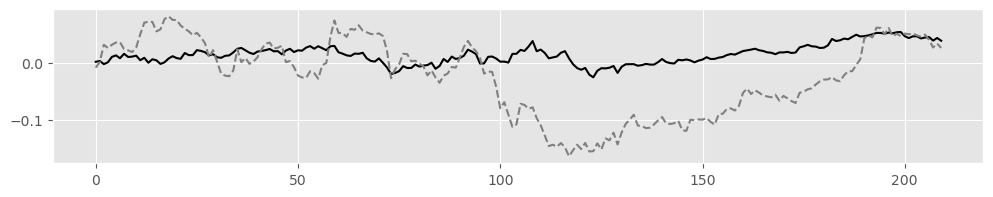


Episode 37/65, episilon=0.15777921478822676

Episode 38/65, episilon=0.14989025404881542

Episode 39/65, episilon=0.14239574134637464

Episode 40/65, episilon=0.1352759542790559

Episode 41/65, episilon=0.1285121565651031


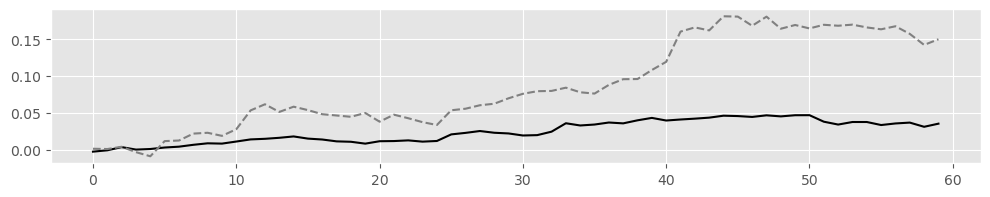


Episode 42/65, episilon=0.12208654873684793

Episode 43/65, episilon=0.11598222130000553

Episode 44/65, episilon=0.11018311023500525

Episode 45/65, episilon=0.10467395472325498

Episode 46/65, episilon=0.09944025698709223


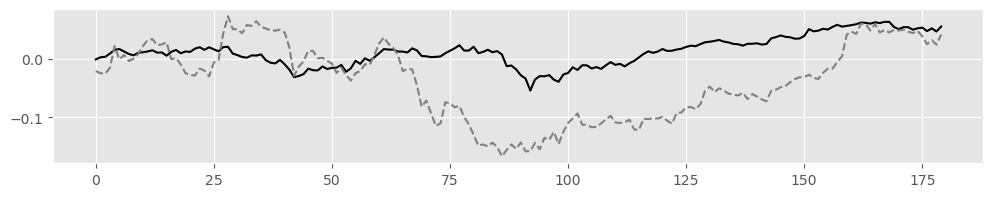


Episode 47/65, episilon=0.09446824413773762

Episode 48/65, episilon=0.08974483193085074

Episode 49/65, episilon=0.0852575903343082

Episode 50/65, episilon=0.08099471081759278

Episode 51/65, episilon=0.07694497527671314


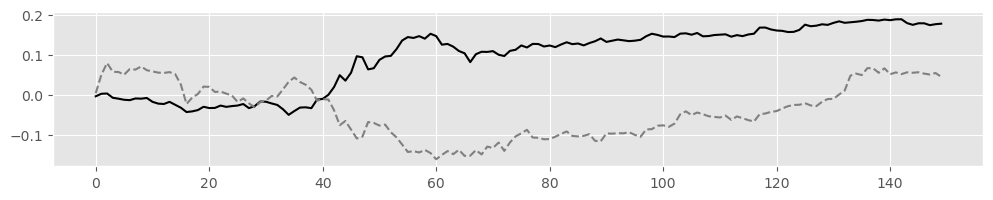


Episode 52/65, episilon=0.07309772651287748

Episode 53/65, episilon=0.0694428401872336

Episode 54/65, episilon=0.0659706981778719

Episode 55/65, episilon=0.0626721632689783

Episode 56/65, episilon=0.059538555105529384


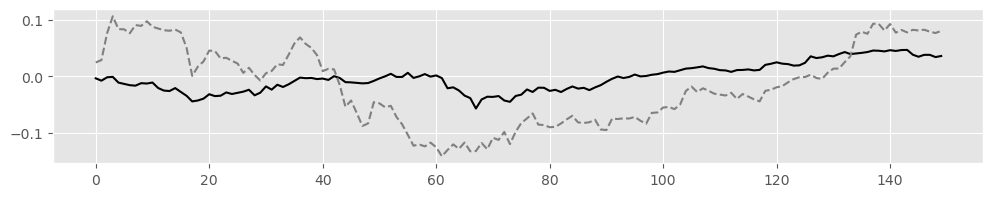


Episode 57/65, episilon=0.05656162735025291

Episode 58/65, episilon=0.053733545982740265

Episode 59/65, episilon=0.05104686868360325

Episode 60/65, episilon=0.04849452524942309

Episode 61/65, episilon=0.04606979898695193


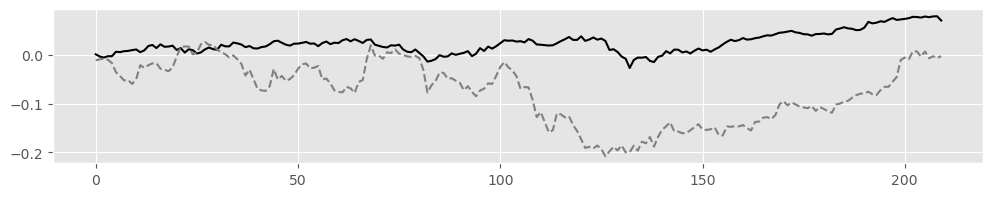


Episode 62/65, episilon=0.04376630903760433

Episode 63/65, episilon=0.041577993585724116

Episode 64/65, episilon=0.03949909390643791

Episode 65/65, episilon=0.03752413921111601


In [98]:
env = PortfolioEnv(# input_file=, 
                   observe_window = 90, 
                   rebalance_window = 30)

q_estimator, stats = q_learning(env, 
                                n_episodes=65,
                                alpha=0.5,
                                epsilon=1.0,
                                epsilon_min=0.01,
                                epsilon_decay_rate=0.95,
                                gamma=0.95,
                                replay_batch_size=10)


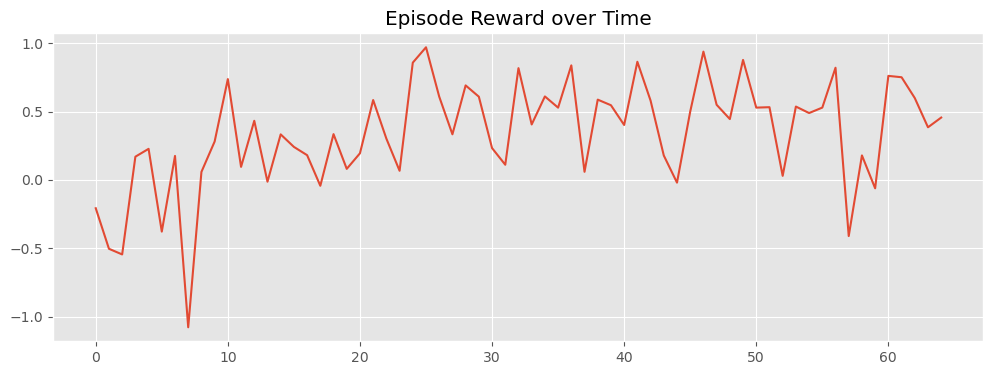

In [105]:
# check if Q converged
plt.figure(figsize = (12, 4))
plt.plot(stats.episode_rewards)
plt.title("Episode Reward over Time")

plt.show()

In [106]:
# save model
# with open('model/q_estimator_0_v1_0.pkl', 'wb') as f:
#     pkl.dump(q_estimator, f)

# load model
with open('model/q_estimator_0_v1_0.pkl', 'rb') as f:
    q_estimator = pkl.load(f)

### Model Testing

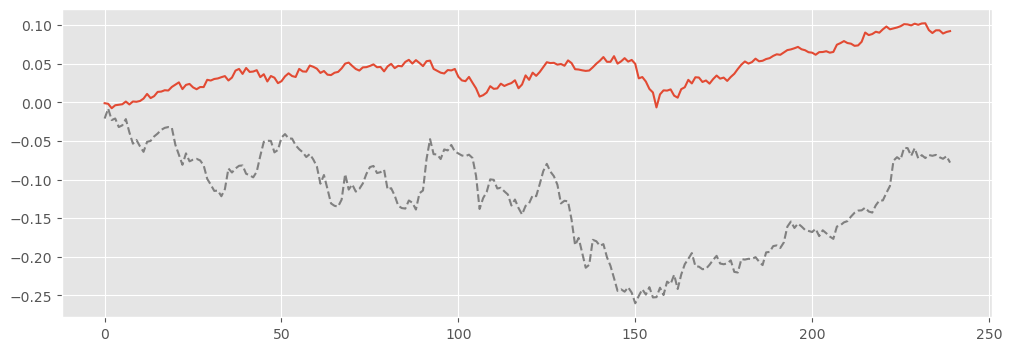

In [100]:
returns_recorder_bm = []
returns_recorder = []
actions_recorder = []

# The policy we're following
policy = epsilon_greedy_policy(env.n_asset)
# Benchmark policy (equal weights)
policy_bm = uni_policy(env.n_asset)
# Reset the environment
state = env.reset()

for t in itertools.count():
    
    # Take a step
    action = policy(state, q_estimator, epsilon=0)  # set epsilon=0 to use the optimal policy
    action_bm = policy_bm(state)
    reward, done, next_state = env.step(action)
    if done:
        break   
    reward_bm = env.check_reward(action_bm) 
    
    # Update recorders and statistics
    returns_recorder_bm.extend(reward_bm[0]) # daily returns of the benchmark portfolio
    actions_recorder.extend(action)
    returns_recorder.extend(reward[0]) # daily returns of the portfolio
    state = next_state

plt.figure(figsize = (12, 4))
plt.plot(np.cumprod(np.array(returns_recorder)+1)-1, ls = '-')
plt.plot(np.cumprod(np.array(returns_recorder_bm)+1)-1, color = 'grey', ls = '--')
plt.show()